<a href="https://colab.research.google.com/github/chandurnischal/sign-language/blob/rahul/DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle

In [ ]:
language = 'asl'
PARENT_FOLDER = '/content/drive/MyDrive/sign-language/{}/'.format(language)
DESTINATION_FOLDER = '/content/drive/MyDrive/sign-language/split/{}'.format(language)


OUTPUT_PATH = '/content/drive/MyDrive/sign-language/model/'
MODEL_PATH = os.path.join(OUTPUT_PATH, '{}_bestDenseNet.keras'.format(language))
HISTORY_PATH = os.path.join(OUTPUT_PATH, '{}_bestDenseNet.pkl'.format(language))


BATCH_SIZE = 32
EPOCHS = 10
TRAIN_DIR = os.path.join(DESTINATION_FOLDER, 'train')
TEST_DIR = os.path.join(DESTINATION_FOLDER, 'test')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define image parameters
img_width, img_height = 100, 100
input_shape = (img_width, img_height, 3)


In [ ]:
# Prepare training and testing data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2120 images belonging to 36 classes.
Found 395 images belonging to 36 classes.


In [ ]:
# Load DenseNet121 model with ImageNet weights, excluding the top classification layer
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the layers
for layer in densenet_model.layers:
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    densenet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(36, activation='softmax')
])

In [ ]:
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True,
                                                save_weights_only=False, mode='max')

# Train the model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=[checkpoint])


In [ ]:
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
best_model = tf.keras.models.load_model(MODEL_PATH)

loss, accuracy = best_model.evaluate(test_generator)
print('Testing Accuracy: {}'.format(accuracy))

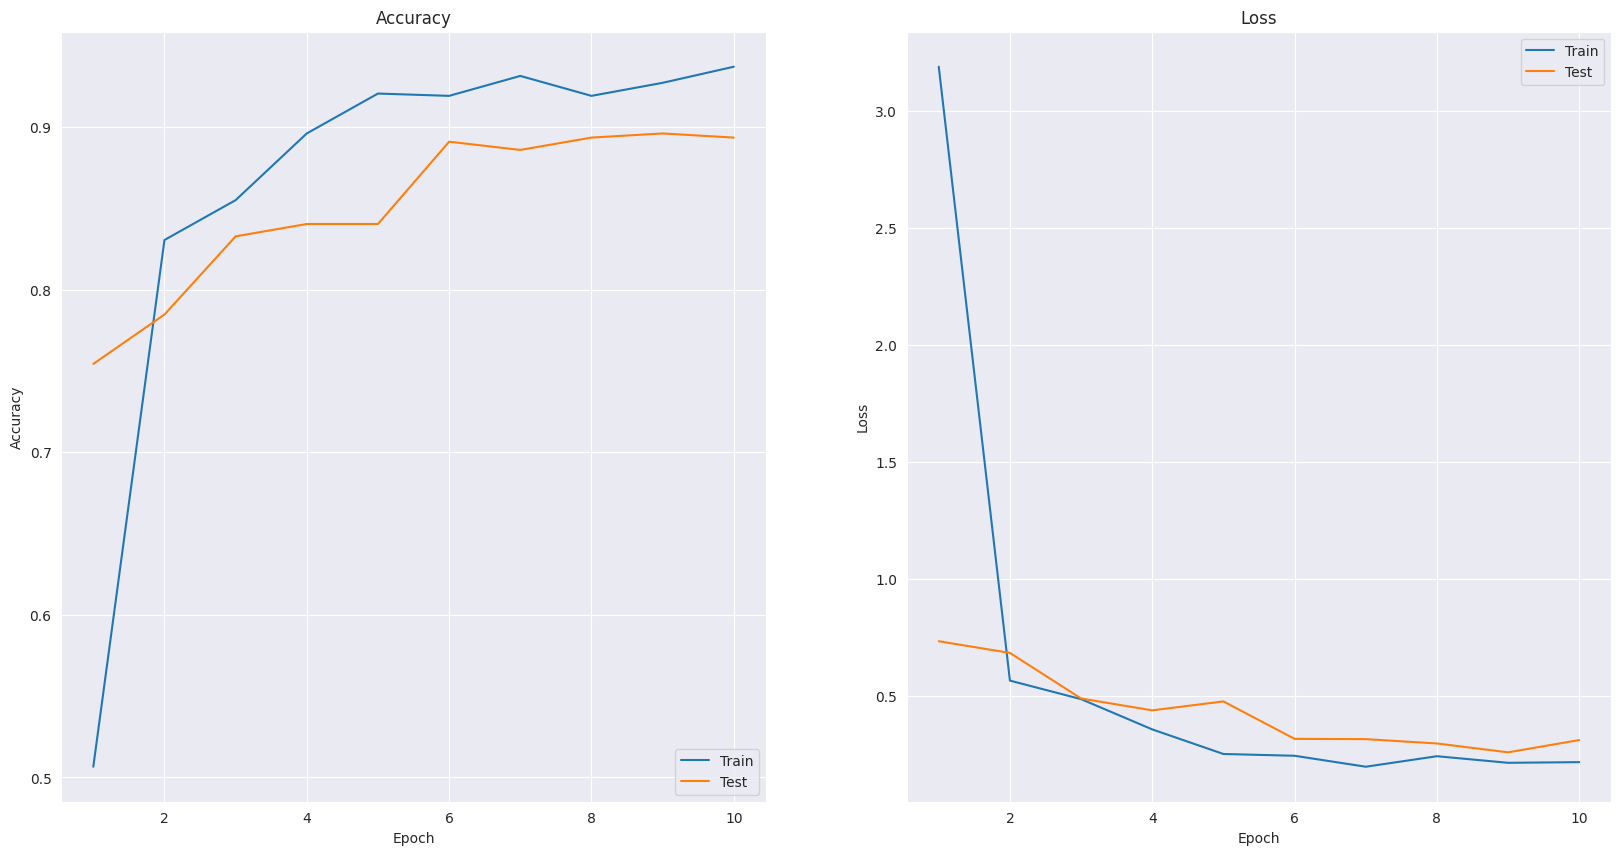

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')

plt.figure(figsize=(20, 10))

x = [i+1 for i in range(10)]

plt.subplot(1, 2, 1)
sns.lineplot(x=x, y=history.history['accuracy'], label='Train')
sns.lineplot(x=x, y=history.history['val_accuracy'], label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
sns.lineplot(x=x, y=history.history['loss'], label='Train')
sns.lineplot(x=x, y=history.history['val_loss'], label='Test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.savefig(os.path.join(OUTPUT_PATH, '{}_DenseNet.png'.format(language)))
plt.show()

13/13 [==============================] - 4s 45ms/step


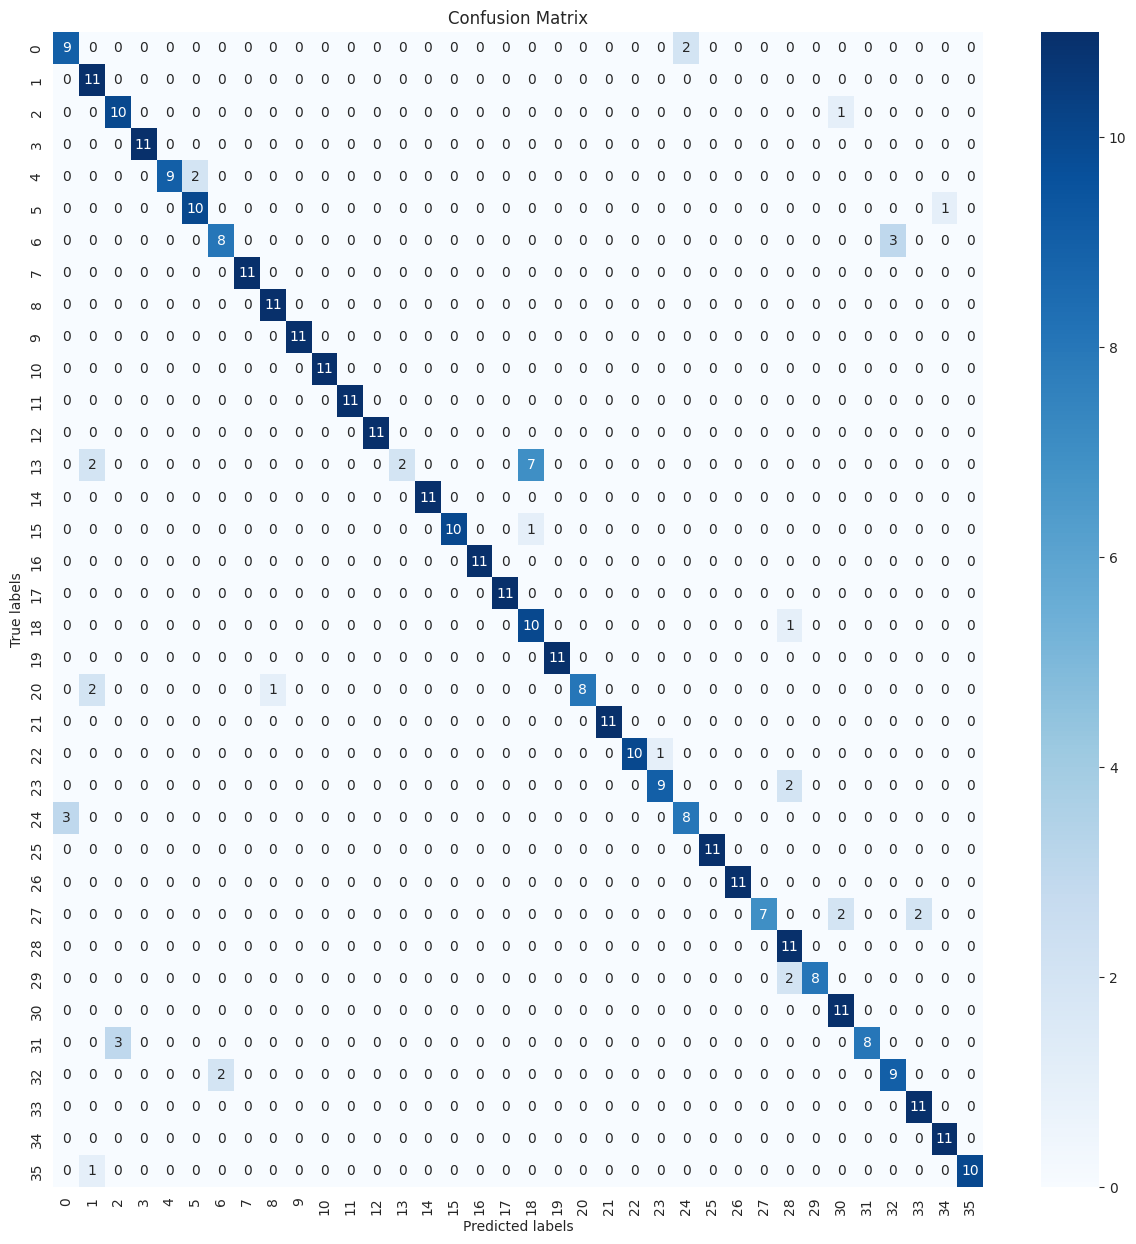

In [ ]:

test_images = []
test_labels = []
for i in range(len(test_generator)):
    batch = test_generator[i]
    test_images.extend(batch[0])
    test_labels.extend(np.argmax(batch[1], axis=1))

test_images = np.array(test_images)
test_labels = np.array(test_labels)
predictions = np.argmax(best_model.predict(test_images), axis=1)

cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(15, 15))
labels = os.listdir(TEST_DIR)
labels.sort()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_PATH, '{}_DenseNet_conf.png'.format(language)))
plt.show()

In [ ]:

densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the layers
for layer in densenet_model.layers:
    layer.trainable = False

model = Sequential([
    densenet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(36, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100, 100),
    batch_size=32,
    class_mode=None,
    shuffle=False)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(100, 100),
    batch_size=32,
    class_mode=None,
    shuffle=False)


hand_sign_features = model.predict(train_generator, verbose=1)
np.save(os.path.join(OUTPUT_PATH, 'hand_sign_features.npy'), hand_sign_features)


asl_features = model.predict(test_generator, verbose=1)
np.save(os.path.join(OUTPUT_PATH, 'asl_features.npy'), asl_features)

print("Features extracted and saved successfully.")


Found 2120 images belonging to 36 classes.
Found 395 images belonging to 36 classes.
13/13 [==============================] - 2s 121ms/step
Features extracted and saved successfully.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image


model = tf.keras.models.load_model(MODEL_PATH)

img_path = '/content/drive/MyDrive/hand.jpg'
img = image.load_img(img_path, target_size=(100, 100))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Rescale to [0, 1]


prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)


class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                'Y', 'Z', 'del', 'nothing', 'space']


print("Predicted class label:", class_labels[predicted_class])
